# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

C:\Program Files\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034L,)
test label shape: (677L,)
dev label shape: (676L,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [4]:
def P1(num_examples=5):
### STUDENT START ###
    section_break = '*' * 80  # Delimiter for each entry
    print section_break
    # Print the first 5 entries from the training set taking care to
    # handle unicode text
    for words, label in zip(train_data[:num_examples],
                            train_labels[:num_examples]):
        print "TEXT: {}\r\nLABEL: {}\r\n{}".format(
            words.encode('utf-8'),
            newsgroups_train.target_names[label],
            section_break)

### STUDENT END ###
P1()



********************************************************************************
TEXT: Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
LABEL: comp.graphics
********************************************************************************
TEXT: 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [5]:
def P2():
### STUDENT START ###
    # Instantiate the count vectorizer and fit / transform our training data.
    vectorizer = CountVectorizer()
    train_data_vect = vectorizer.fit_transform(train_data)

    # A
    print "a. Our vocabulary has {} entries, "\
        "there are on average {:0.2f} non-zero features per example.".format(
            train_data_vect.shape[1],
            1.0 * train_data_vect.nnz / train_data_vect.shape[0])
    # B
    print "b. The 0th and last feature strings are '{}' and '{}' respectively"\
        ".".format(sorted(vectorizer.get_feature_names())[0],
                   sorted(vectorizer.get_feature_names())[-1])
    # C
    my_vocab = ["atheism", "graphics", "space", "religion"]
    vocab_vectorizer = CountVectorizer(vocabulary=my_vocab)
    vocab_td_vect = vocab_vectorizer.fit_transform(train_data)
    print "c. Using the supplied vocabulary there are on average {:0.2f} "\
        "non-zero features per example.".format(
            1.0 * vocab_td_vect.nnz / vocab_td_vect.shape[0])
    # D
    ngram_vectorizer = CountVectorizer(analyzer="char_wb", ngram_range=(2, 3))
    ngram_td_vect = ngram_vectorizer.fit_transform(train_data)
    print "d. Using bigram and trigram features, the new vocabulary has {} "\
        "entries.".format(
            ngram_td_vect.shape[1])
    # E
    min_freq = 10
    min_df_vectorizer = CountVectorizer(min_df=min_freq)
    min_df_td_vect = min_df_vectorizer.fit_transform(train_data)
    print "e. The vocabulary has {} entries when the minimum word frequency"\
        " is {}.".format(
            min_df_td_vect.shape[1],
            min_freq)
    # F
    dev_vectorizer = CountVectorizer()
    dev_data_vect = dev_vectorizer.fit_transform(dev_data)
    num_common_vocab = len(list(set(vectorizer.get_feature_names())
                                & set(dev_vectorizer.get_feature_names())))
    num_dev_not_in_train = dev_data_vect.shape[1] - num_common_vocab
    dev_fract_missing = 100.0 * num_dev_not_in_train / dev_data_vect.shape[1]
    print "f. {:0.2f}% of vocabulary entries in dev data do not appear in "\
        "training data.".format(dev_fract_missing)

### STUDENT END ###
P2()


a. Our vocabulary has 26879 entries, there are on average 96.71 non-zero features per example.
b. The 0th and last feature strings are '00' and 'zyxel' respectively.
c. Using the supplied vocabulary there are on average 0.27 non-zero features per example.
d. Using bigram and trigram features, the new vocabulary has 28954 entries.
e. The vocabulary has 3064 entries when the minimum word frequency is 10.
f. 24.79% of vocabulary entries in dev data do not appear in training data.


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [6]:
def P3():
### STUDENT START ###
    # Use default CountVectorizer options
    vectorizer = CountVectorizer()
    train_data_vect = vectorizer.fit_transform(train_data)
    dev_data_vect = vectorizer.transform(dev_data)

    # kNN model
    # Find best k value using gridSearchCV
    grid_knn = GridSearchCV(
        KNeighborsClassifier(),
        {'n_neighbors': [k for k in range(1, 101)]})
    grid_knn.fit(train_data_vect, train_labels)
    # Analyze kNN model
    # Note: Using the weighted average to account for different numbers of each
    #   label
    print "kNN:\r\n" \
        "\tOptimal k: {}\r\n" \
        "\tAccuracy: {:.2f}%\r\n" \
        "\tf1 score: {:.3f}\r\n".format(
            grid_knn.best_params_['n_neighbors'],
            100.0 * grid_knn.best_score_,
            metrics.f1_score(
                dev_labels,
                grid_knn.predict(dev_data_vect),
                average="weighted"))

    # Multinomial Naive Bayes model
    # Find best alpha value using gridSearchCV
    grid_nb = GridSearchCV(
        MultinomialNB(),
        {"alpha": [a / 100.0 for a in range(1, 101)]})
    grid_nb.fit(train_data_vect, train_labels)
    # Analyze NB model
    print "Naive Bayes:\r\n" \
        "\tOptimal alpha: {}\r\n" \
        "\tAccuracy: {:.2f}%\r\n"\
        "\tf1 score: {:.3f}\r\n".format(
            grid_nb.best_params_['alpha'],
            100.0 * grid_nb.best_score_,
            metrics.f1_score(
                dev_labels,
                grid_nb.predict(dev_data_vect),
                average="weighted"))

    # Logistic regression model
    # Find best C value using gridSearchCV
    grid_lr = GridSearchCV(
        LogisticRegression(),
        {"C": [a / 100.0 for a in range(1, 101)]})
    grid_lr.fit(train_data_vect, train_labels)
    print "Logistic Regression:\r\n" \
        "\tOptimal C: {}\r\n" \
        "\tAccuracy: {:.3f}\r\n" \
        "\tf1 score: {:.3f}\r\n".format(
            grid_lr.best_params_['C'],
            100 * grid_lr.best_score_,
            metrics.f1_score(
                dev_labels,
                grid_lr.predict(dev_data_vect),
                average="weighted"))

    # Get sum of squared weights for 10 C values between 0.1 and 1
    for c in np.arange(0.1, 1.1, 0.1):
        lr_clf = LogisticRegression(C=c)
        lr_clf.fit(train_data_vect, train_labels)
        print ("C = {}: Sum of Weights^2: {}".format(
            c,
            np.round(np.square(lr_clf.coef_).sum(axis=1), 2)))

### STUDENT END ###
P3()


kNN:
	Optimal k: 96
	Accuracy: 44.44%
	f1 score: 0.448

Naive Bayes:
	Optimal alpha: 0.02
	Accuracy: 82.89%
	f1 score: 0.783

Logistic Regression:
	Optimal C: 0.17
	Accuracy: 77.679
	f1 score: 0.708

C = 0.1: Sum of Weights^2: [ 27.13  24.66  27.46  23.02]
C = 0.2: Sum of Weights^2: [ 49.75  42.75  49.32  42.65]
C = 0.3: Sum of Weights^2: [ 69.29  57.87  67.9   59.76]
C = 0.4: Sum of Weights^2: [ 86.74  71.16  84.28  75.07]
C = 0.5: Sum of Weights^2: [ 102.67   83.09   99.03   89.  ]
C = 0.6: Sum of Weights^2: [ 117.2    94.03  112.54  101.85]
C = 0.7: Sum of Weights^2: [ 130.86  104.18  124.99  113.78]
C = 0.8: Sum of Weights^2: [ 143.63  113.6   136.62  125.08]
C = 0.9: Sum of Weights^2: [ 155.59  122.48  147.66  135.69]
C = 1.0: Sum of Weights^2: [ 167.01  130.95  157.97  145.74]


ANSWER:
a. Why doesn't nearest neighbors work well for this problem?
    Due to the "curse of dimensionality", about 26800, each point is relatively far from any other point. Specifically, there are a large number of possible words but each document only contains a small subset of them, therefore, to the k-NN classifier each document (bag of words) is difficult to distinguish from any other document.
    
b. Any ideas why logistic regression doesn't work as well as Naive Bayes?
    Logistic regression assumes a linear feature relationship for all class labels which is unlikely. Naive Bayes assumes conditional independence of features given class which is more likely for a "bag of words".
    
c. Briefly explain the relationship between the sum and the value of C.
    Smaller values for C increase regularization, this adds a penalty for larger coefficients reducing them towards zero. As C increases the coefficients can become larger which might lead to overfitting the data.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [12]:
def P4():
### STUDENT START ###
    print 'Label names (for reference):\r\n{}\r\n'.format(
        newsgroups_train.target_names)
    ngram_labels = [None, "Unigram", "Bigram"]
    for n_gram in range(1, 3):
        # Instantiate the count vectorizer and fit / transform our
        # training data using either unigram or bigram.
        vectorizer = CountVectorizer(ngram_range=(n_gram, n_gram))
        train_data_vect = vectorizer.fit_transform(train_data)

        # Fit logistic regression classifier
        lr_clf = LogisticRegression()
        lr_clf.fit(train_data_vect, train_labels)

        # Use argsort to get the indicies of the sorted coeficient array, then
        # take the top 5 and flatten to get list of indicies for the 20 highest
        # weighted features
        max_weights = np.argsort(lr_clf.coef_, axis=1)[:, -5:].flatten()

        # Display results
        vocabulary = np.array(vectorizer.get_feature_names())
        print "Top 20 {}'s:\r\n{}\r\n\r\nFeature Weights:\r\n{}\r\n" \
            "Average Weight: {}\r\n".format(
                ngram_labels[n_gram],
                np.core.defchararray.encode(vocabulary[max_weights]),
                np.transpose(np.round(lr_clf.coef_[:, max_weights], 2)),
                np.mean(np.abs(np.round(lr_clf.coef_[:, max_weights], 2))))

### STUDENT END ###
P4()


Label names (for reference):
['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

Top 20 Unigram's:
['atheism' 'religion' 'bobby' 'atheists' 'deletion' 'computer' '3d' 'file'
 'image' 'graphics' 'spacecraft' 'launch' 'nasa' 'orbit' 'space' 'order'
 'fbi' 'blood' 'christian' 'christians']

Feature Weights:
[[ 0.94 -0.41 -0.45 -0.43]
 [ 0.95 -0.62 -0.79 -0.06]
 [ 0.99 -0.22 -0.34 -0.46]
 [ 1.03 -0.1  -0.32 -0.84]
 [ 1.13 -0.4  -0.42 -0.4 ]
 [ 0.14  0.98 -0.68 -0.49]
 [-0.36  1.12 -0.7  -0.38]
 [-0.33  1.27 -0.81 -0.63]
 [-0.58  1.35 -0.83 -0.47]
 [-0.76  1.94 -1.34 -0.76]
 [-0.36 -0.39  0.92 -0.38]
 [-0.47 -0.47  0.94 -0.33]
 [-0.57 -0.48  1.01 -0.47]
 [-0.41 -0.67  1.23 -0.63]
 [-1.26 -1.32  2.16 -1.17]
 [-0.79 -0.08 -0.15  0.9 ]
 [-0.31 -0.27 -0.45  0.91]
 [-0.53 -0.11 -0.32  1.05]
 [-0.61 -0.42 -0.27  1.12]
 [-0.74 -0.41 -0.53  1.15]]
Average Weight: 0.67475

Top 20 Bigram's:
['you are' 'look up' 'cheers kent' 'was just' 'claim that' 'out there'
 'is there' 'in advance

ANSWER: Compared to the unigram features the bigram features don't seem to relate as much to the label names. Each top 20 unigram word directly correlates to the labels while only some of the bigrams do. Looking at the feature weights the unigram weights are also more distinct than the bigram weights, the average unigram weights is higher than the average bigram weight.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [13]:
def empty_preprocessor(s):
    return s


def better_preprocessor(s):
### STUDENT START ###
    # lowercases and re-encode
    s = s.lower().encode('utf-8')
    # Remove non-alphanumeric characters
    s = re.sub(r"[^0-9a-zA-Z ]", r" ", s)
    # Replace long numbers (4 or more digits) with a single token 5555"
    s = re.sub(r"[0-9]{4,}", "5555", s)
    # Replace letter sequences with a single token aaaa"
    for letter in "abcdefghijklmnopqrstuvwxyz":
        s = re.sub(letter + r"{4,}", "aaaa", s)
    # Remove common suffixes
    # Note: Removing additional suffixes decreases F1 score
    s = re.sub(r"s\b|ed\b|y\b", r"", s)
    return s
### STUDENT END ###


def P5():
### STUDENT START ###
    vectorizer = CountVectorizer()
    lr_clf = LogisticRegression()

    # Pre_process text with empty preprocessor
    test_data_procd = [empty_preprocessor(w) for w in train_data]
    dev_data_procd = [empty_preprocessor(w) for w in dev_data]
    train_data_vect = vectorizer.fit_transform(test_data_procd)
    dev_data_vect = vectorizer.transform(dev_data_procd)
    lr_clf.fit(train_data_vect, train_labels)
    orig_vocab = len(vectorizer.get_feature_names())
    orig_f1 = metrics.f1_score(
        dev_labels,
        lr_clf.predict(dev_data_vect),
        average="weighted")
    print "No Preprocessing:\r\nVocab Size: {}\r\nF1 score: {}\r\n".format(
        len(vectorizer.get_feature_names()),
        orig_f1)

    # Pre_process text with better preprocessor
    test_data_procd = [better_preprocessor(w) for w in train_data]
    dev_data_procd = [better_preprocessor(w) for w in dev_data]
    train_data_vect = vectorizer.fit_transform(test_data_procd)
    dev_data_vect = vectorizer.transform(dev_data_procd)
    lr_clf.fit(train_data_vect, train_labels)
    proc_vocab = len(vectorizer.get_feature_names())
    proc_f1 = metrics.f1_score(
        dev_labels,
        lr_clf.predict(dev_data_vect),
        average="weighted")
    print "With Preprocessing:\r\nVocab Size: {}\r\nF1 score: {}\r\n".format(
        len(vectorizer.get_feature_names()),
        proc_f1)

    print "Using preprocessing reduces the vocabulary size by {}" \
        " or {:.2f}%.\r\nF1 Score delta: {:.3f}".format(
            orig_vocab-proc_vocab,
            100.0 * (orig_vocab-proc_vocab) / orig_vocab,
            proc_f1-orig_f1)

### STUDENT END ###
P5()

No Preprocessing:
Vocab Size: 26879
F1 score: 0.694417287185

With Preprocessing:
Vocab Size: 21948
F1 score: 0.718700632202

Using preprocessing reduces the vocabulary size by 4931 or 18.35%.
F1 Score delta: 0.024


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

L2 regularization
# nonzero weights: 107516.
Accuracy: 0.699704142012

L1 regularization
# nonzero weights: 1599.
Accuracy: 0.687869822485

The number of nonzero weights using L1 regularization is significantly smaller than with L2 regularization only.

L2 regularization with reduced vocabulary
# nonzero weights: 3808.
Accuracy: 0.680473372781



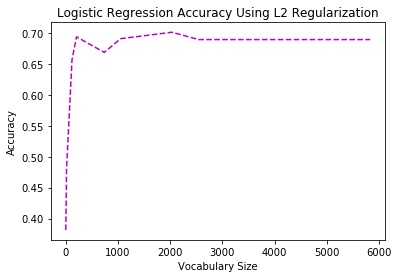

In [16]:

def P6():
# Keep this random seed here to make comparison easier.
    np.random.seed(0)
### STUDENT START ###
    # Instantiate the count vectorizer and fit / transform our training data.
    vectorizer = CountVectorizer()
    train_data_vect = vectorizer.fit_transform(train_data)
    dev_data_vect = vectorizer.transform(dev_data)

    # Logistic regression using L1 regularization
    lr_clf = LogisticRegression(penalty='l2')
    lr_clf.fit(train_data_vect, train_labels)
    print "L2 regularization\r\n# nonzero weights: {}.\r\n" \
        "Accuracy: {}\r\n".format(
            np.count_nonzero(lr_clf.coef_),
            lr_clf.score(dev_data_vect, dev_labels))

    # Logistic regression using L1 regularization
    lr_clf = LogisticRegression(penalty='l1')
    lr_clf.fit(train_data_vect, train_labels)
    print "L1 regularization\r\n# nonzero weights: {}.\r\n" \
        "Accuracy: {}\r\n".format(
            np.count_nonzero(lr_clf.coef_),
            lr_clf.score(dev_data_vect, dev_labels))

    print "The number of nonzero weights using L1 regularization is" \
        " significantly smaller than with L2 regularization only.\r\n"

    # Get features with non-zero weights
    # Note: np.unique eliminates repeats
    nz_features = np.unique(np.nonzero(lr_clf.coef_)[1])
    nz_vocab = np.array(vectorizer.get_feature_names())[nz_features]

    # Re-fit with non zero weighted vocab
    vectorizer = CountVectorizer(vocabulary=nz_vocab)
    train_data_vect = vectorizer.fit_transform(train_data)
    dev_data_vect = vectorizer.transform(dev_data)

    # Create logistic regression using L2 regularization and new model
    lr_clf = LogisticRegression(penalty='l2')
    lr_clf.fit(train_data_vect, train_labels)
    print "L2 regularization with reduced vocabulary\r\n" \
        "# nonzero weights: {}.\r\n" \
        "Accuracy: {}\r\n".format(
            np.count_nonzero(lr_clf.coef_),
            lr_clf.score(dev_data_vect, dev_labels))

    # Test different C values
    vocab_sizes = []
    accuracies = []
    for c in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]:
        # Logistic regression using L1 regularization
        vectorizer = CountVectorizer()
        train_data_vect = vectorizer.fit_transform(train_data)
        lr_clf = LogisticRegression(penalty='l1', C=c, tol=0.01)
        lr_clf.fit(train_data_vect, train_labels)

        # Get features with non-zero weights
        nz_features = np.unique(np.nonzero(lr_clf.coef_)[1])
        nz_vocab = np.array(vectorizer.get_feature_names())[nz_features]
        vocab_sizes.append(len(nz_vocab))

        # Logistic regression using L2 regularization and reduced vocab
        vectorizer = CountVectorizer(vocabulary=nz_vocab)
        train_data_vect = vectorizer.fit_transform(train_data)
        dev_data_vect = vectorizer.transform(dev_data)
        lr_clf = LogisticRegression(penalty='l2', tol=0.01)
        lr_clf.fit(train_data_vect, train_labels)
        accuracies.append(lr_clf.score(dev_data_vect, dev_labels))

    # Plot vocab size vs accuracy
    plt.plot(vocab_sizes, accuracies, "m--")
    plt.xlabel("Vocabulary Size")
    plt.ylabel("Accuracy")
    plt.title("Logistic Regression Accuracy Using L2 Regularization")
    ### STUDENT END ###

P6()


(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [19]:
def stringify_freq_list(counts_list):
    s = ""
    for word, count in counts_list:
        s = s + "\t" + str(count) + " : " + word + "\r\n"
    return s


def P7():
### STUDENT START ###
    # Instantiate the TFIDF vectorizer and fit / transform our training data.
    vectorizer = TfidfVectorizer()
    train_data_vect = vectorizer.fit_transform(train_data)
    dev_data_vect = vectorizer.transform(dev_data)

    # Logistic regression using C=100
    lr_clf = LogisticRegression(C=100)
    lr_clf.fit(train_data_vect, train_labels)
    probabilities = lr_clf.predict_proba(dev_data_vect)

    # Calculate R values
    r_vals = []
    for index, example in enumerate(probabilities):
        max_p = np.amax(example)
        predict_p = example[dev_labels[index]]
        r_vals.append(max_p / predict_p)

    # Get the top 3 R values
    r_vals = np.array(r_vals)
    r_vals_top3_indices = np.argsort(r_vals)[-3:]

    # Analyze results
    from collections import Counter
    for i in r_vals_top3_indices:
        print "R: {}\r\nPredicted category: {}\r\nCorrect category: {}\r\n" \
            "Word Frequencies:\r\n{}\r\n".format(
                r_vals[i],
                newsgroups_train.target_names[
                    np.argsort(probabilities[i])[-1:][0]],
                newsgroups_train.target_names[dev_labels[i]],
                stringify_freq_list(
                    Counter(
                        dev_data[i]
                        .lower()
                        .encode('utf-8')
                        .split()).most_common()))

## STUDENT END ###
P7()


R: 287.307166293
Predicted category: talk.religion.misc
Correct category: alt.atheism
Word Frequencies:
	2 : in
	2 : a
	2 : of
	2 : the
	1 : fired
	1 : second
	1 : gunman
	1 : children
	1 : 24
	1 : story
	1 : space
	1 : lone
	1 : two
	1 : course,
	1 : killed
	1 : were,
	1 : window,
	1 : who
	1 : seconds...
	1 : eight
	1 : by
	1 : bullets


R: 325.003977561
Predicted category: comp.graphics
Correct category: talk.religion.misc
Word Frequencies:
	2 : a
	2 : of
	2 : can
	2 : the
	1 : site
	1 : if
	1 : ftp
	1 : possible.
	1 : please
	1 : anyone
	1 : version
	1 : internet
	1 : email
	1 : me
	1 : online
	1 : mormon.
	1 : obtain
	1 : address
	1 : i
	1 : provide
	1 : where
	1 : book


R: 929.357446388
Predicted category: comp.graphics
Correct category: talk.religion.misc
Word Frequencies:
	18 : the
	13 : of
	12 : a
	10 : in
	9 : and
	8 : to
	6 : for
	6 : this
	5 : postscript
	5 : is
	5 : you
	4 : be
	4 : book
	3 : dba
	3 : rtf
	3 : are
	3 : ftp
	3 : by
	3 : been
	3 : that
	3 : can
	3 : have
	3

ANSWER:
How is TfidfVectorizer different from the CountVectorizer?
    CountVectorizer converts a document into a matrix of token (word) counts whereas TfidfVectorizer converts the document into a matrix of tf-idf values, which are term frequency multiplied by inverse document frequency. Unlike countVectorizer, tf-idf values decrease the weighting of words that appear at high frequencies across multiple documents (the idf part), like the word "the". This ensures that common words are not significant factors in determining the document class.

What kinds of mistakes is the model making?
    Of the examples with the highest R value, none are classified correctly. While tf-idf removes the effect of words that appear across the entire corpus it appears to cause the relative weight of key terms to effectively cancel each other out. As an example, in the second document of the top 3 R values group there are more individual words associated with computers than with religion (eg. "ftp", "internet", "email", and "online" vs "mormon", and maybe "book") even though the correct document category is "talk.religion.misc". Some possible fixes for this would be using bi or tri-gram features, or somehow applying a higher weight to proper nouns within a document.

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.